In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

sys.path.append("../")
from evraz.settings import Connection

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("../../data/raw/")

In [3]:
conn = Connection().open_conn().ping()

## Признаки, связанные с отходящими газами

In [4]:
df_gas = conn.read_query("""
select "NPLV",
       -- мин, среднее, макс, откл
       -- объём
       min("V") min_V,
       max("V") max_V,
       avg("V") avg_V,
       stddev("V") srd_V,
       -- температура
       min("T") min_T,
       max("T") max_T,
       avg("T") avg_T,
       stddev("T") srd_T,
       -- AR
       min("AR") min_AR,
       max("AR") max_AR,
       avg("AR") avg_AR,
       stddev("AR") srd_AR,
       -- CO
       min("CO") min_CO,
       max("CO") max_CO,
       avg("CO") avg_CO,
       stddev("CO") srd_CO,
       -- CO2
       min("CO2") min_CO2,
       max("CO2") max_CO2,
       avg("CO2") avg_CO2,
       stddev("CO2") srd_CO2,
       -- H2
       min("H2") min_H2,
       max("H2") max_H2,
       avg("H2") avg_H2,
       stddev("H2") srd_H2,
       -- O2
       min("O2") min_O2,
       max("O2") max_O2,
       avg("O2") avg_O2,
       stddev("O2") srd_O2,
       -- N2
       min("N2") min_N2,
       max("N2") max_N2,
       avg("N2") avg_N2,
       stddev("N2") srd_N2
from gas_train gas
group by "NPLV"
""")

In [7]:
df_target = conn.read_query("select * from target_train")
df_target

,NPLV,TST,C
0,510008.0,1690.0,0.060
1,510009.0,1683.0,0.097
2,510010.0,1662.0,0.091
3,510011.0,1609.0,0.410
4,510012.0,1682.0,0.120
...,...,...,...
2058,512318.0,1626.0,0.145
2059,512319.0,1643.0,0.087
2060,512320.0,1615.0,0.141
2061,512321.0,1654.0,0.270


<AxesSubplot:xlabel='TST', ylabel='avg_v'>

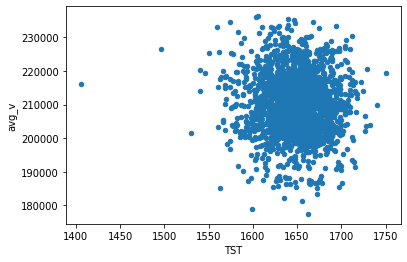

In [20]:
df = pd.merge(df_target, df_gas, on="NPLV", how="left")
df.plot.scatter('TST', 'avg_v')

In [21]:
df = df.query(f"TST >= {df.TST.quantile(0.01)}").query(f"TST <= {df.TST.quantile(0.99)}")
df.shape

(2027, 35)

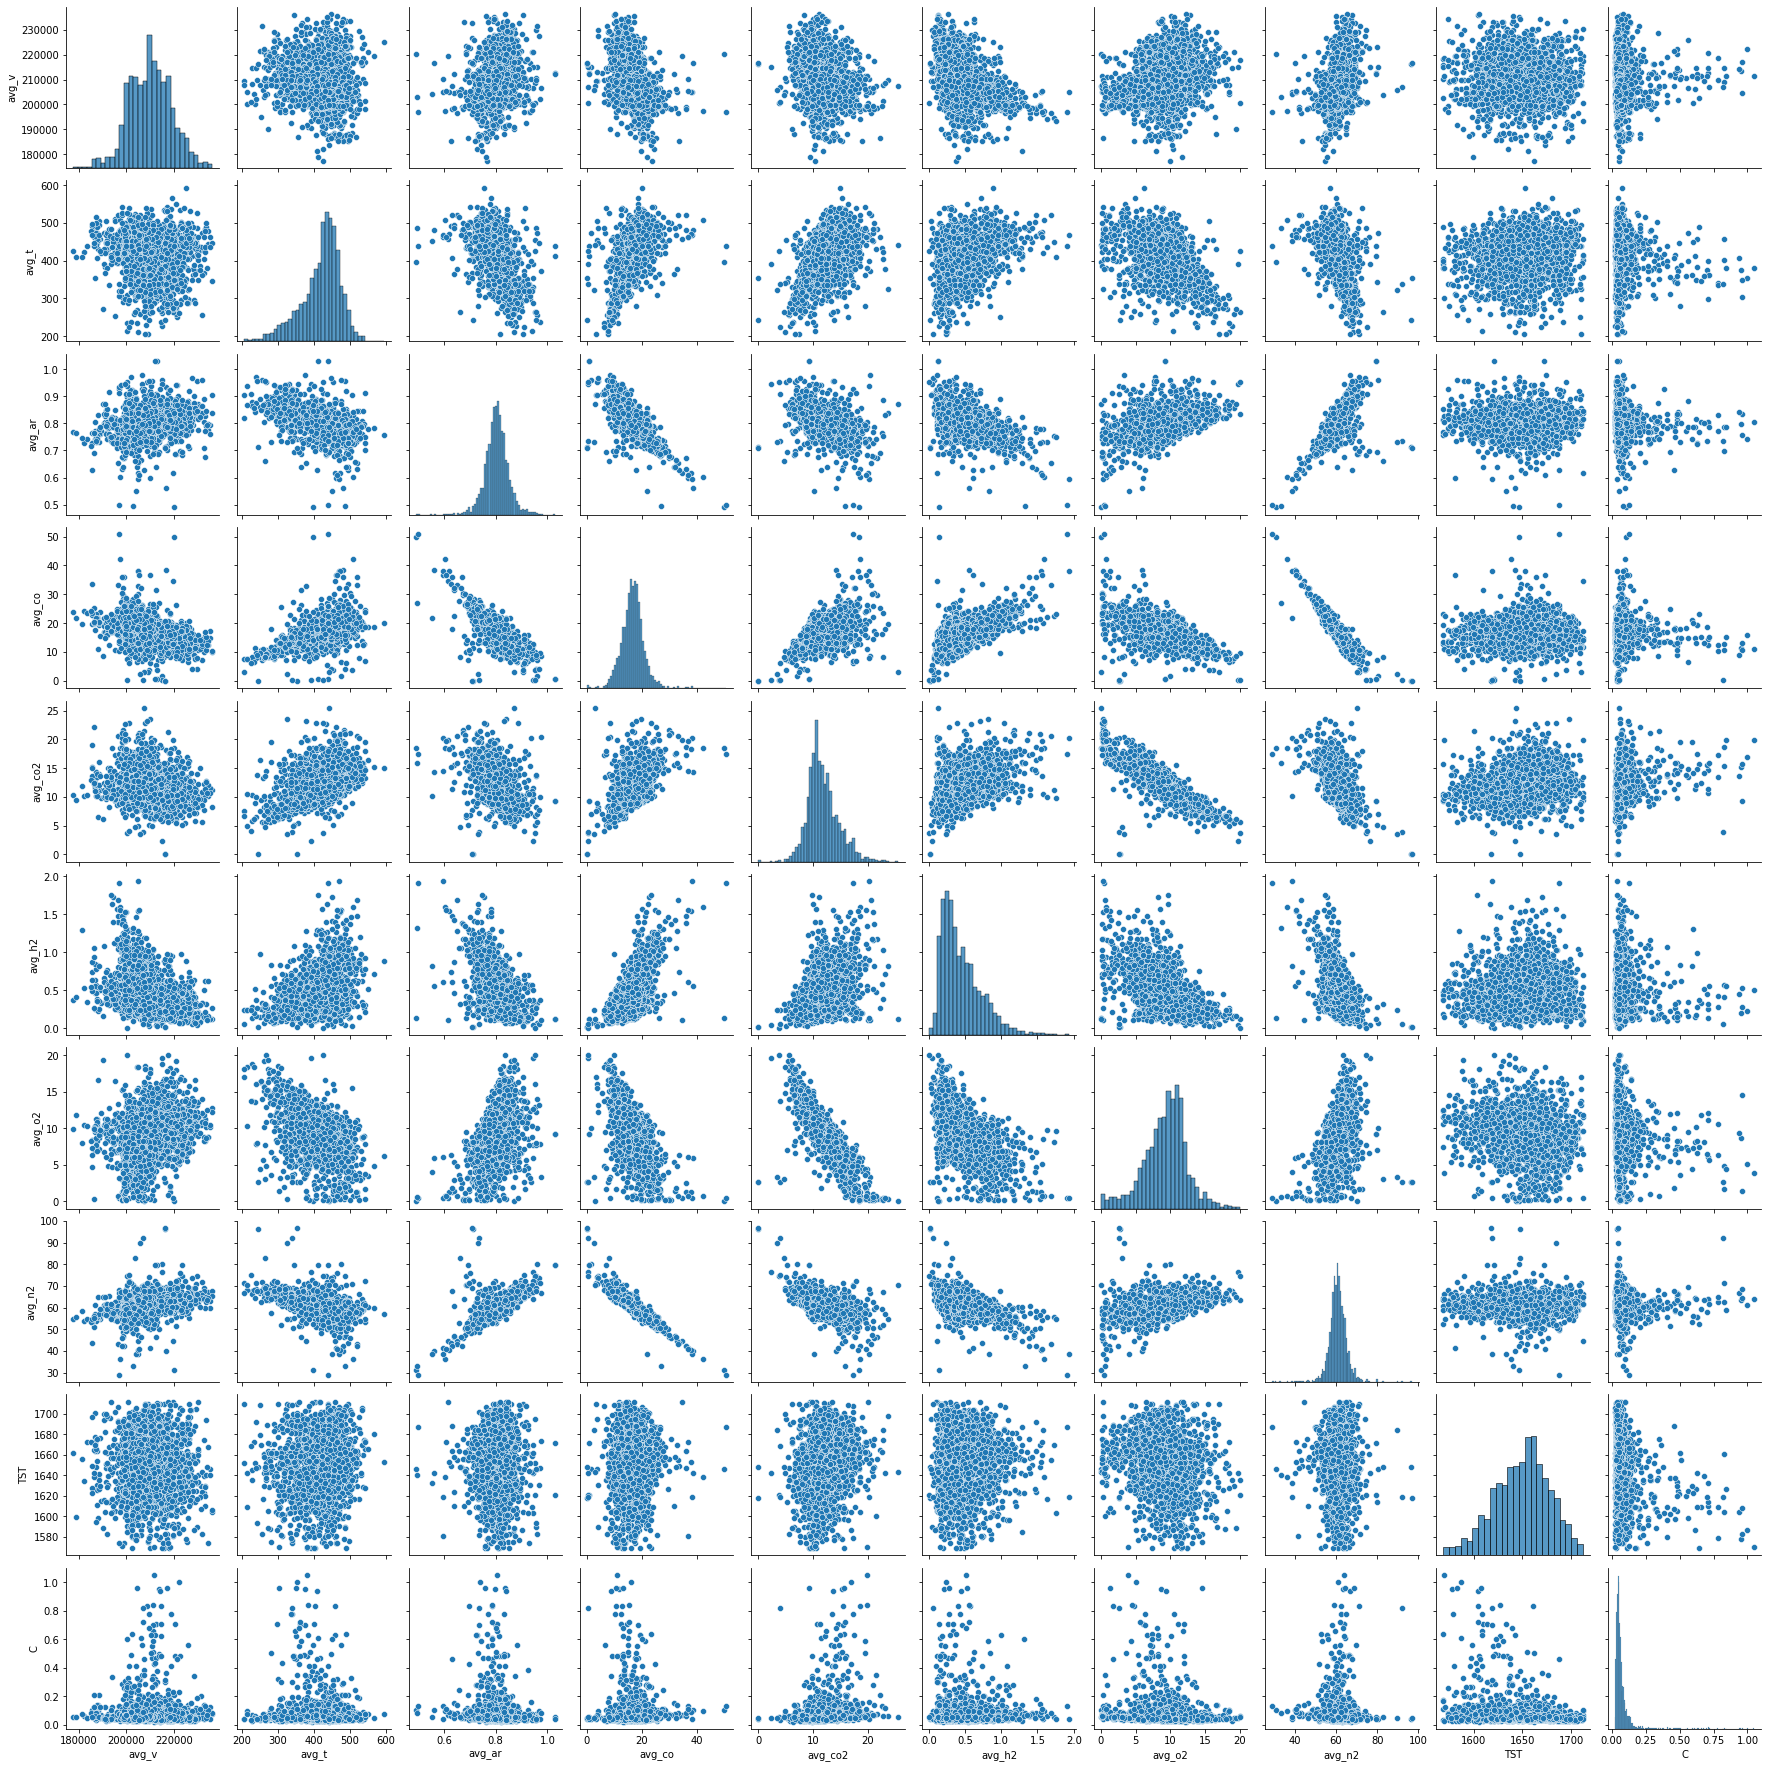

In [22]:
sns.pairplot(
    data=df[df.columns[df.columns.str.contains("avg_")].tolist() + ['TST', 'C']],
)

In [23]:
df.TST.quantile([0.001, 0.01, 0.05, 0.5, 0.95, 0.99, 0.999])

0.001    1569.00
0.010    1578.26
0.050    1600.00
0.500    1652.00
0.950    1694.00
0.990    1706.00
0.999    1712.00
Name: TST, dtype: float64

## Случайный процесс плавки

In [35]:
proc = conn.read_query("""
select * from gas_train where "NPLV" = 510008 order by "Time"
""")
proc

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure
0,510008.0,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,0.009229,0.893243,0.0,0.0,13.085938
1,510008.0,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,0.008390,0.892948,0.0,0.0,13.085938
2,510008.0,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,0.007551,0.892653,0.0,0.0,13.085938
3,510008.0,2021-01-01 03:08:14.437,218475.359375,261.805573,18.752177,80.150724,0.088367,0.119184,0.006712,0.892358,0.0,0.0,13.093172
4,510008.0,2021-01-01 03:08:15.437,218369.359375,260.763885,18.761905,80.156883,0.088571,0.104286,0.005873,0.892063,0.0,0.0,13.093172
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,510008.0,2021-01-01 03:51:06.437,218369.359375,131.944443,9.916870,78.370371,0.010074,10.185237,0.550623,0.973858,0.0,0.0,13.389757
2556,510008.0,2021-01-01 03:51:07.437,219426.875000,131.944443,9.929288,78.373759,0.010222,10.170386,0.549763,0.973769,0.0,0.0,13.389757
2557,510008.0,2021-01-01 03:51:08.437,219637.750000,131.944443,9.941707,78.377146,0.010370,10.155534,0.548902,0.973680,0.0,0.0,13.389757
2558,510008.0,2021-01-01 03:51:09.437,219321.343750,131.944443,9.954125,78.380534,0.010519,10.140683,0.548042,0.973591,0.0,0.0,13.389757


In [44]:
conn.read_query("select * from chronom_train where \"NPLV\" = 510008 order by \"VR_NACH\"")

,a,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
0,35171.0,510008.0,межпл.прост.,межпл. простой,2011-01-01 10:28:13,2011-01-01 10:32:15,NaN
1,35162.0,510008.0,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
2,35163.0,510008.0,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
3,35164.0,510008.0,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
4,35165.0,510008.0,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN
5,35166.0,510008.0,межпл.прост.,Отсутствие O2,2021-01-01 03:06:09,2021-01-01 03:08:15,NaN
6,26.0,510008.0,опер,Завалка лома,2021-01-01 03:08:11,2021-01-01 03:08:27,NaN
7,27.0,510008.0,опер,Нагрев лома,2021-01-01 03:08:27,2021-01-01 03:14:32,NaN
8,33235.0,510008.0,опер,Нагрев лома,2021-01-01 03:08:27,2021-01-01 03:14:32,2909.0
9,28.0,510008.0,опер,Заливка чугуна,2021-01-01 03:15:02,2021-01-01 03:18:25,NaN


<AxesSubplot:xlabel='Time'>

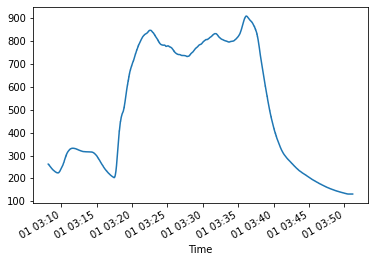

In [41]:
proc.set_index("Time")['T'].plot.line()